In [1]:
from rasterhandler import RasterHandler,AreaType
from analyzer import Analyzer

In [2]:
_unburned_tiff_path = "./Satellite_burned_area_dataset_part1/EMSR213_01VESUVIO_02GRADING_MAP_v2_vector/sentinel2_2017-06-27.tiff"
_burned_tiff_path = "./Satellite_burned_area_dataset_part1/EMSR213_01VESUVIO_02GRADING_MAP_v2_vector/sentinel2_2017-07-17.tiff"

In [3]:
_raster_data=RasterHandler(_burned_tiff_path,_unburned_tiff_path)
_analyzer=Analyzer()

In [4]:
_raster_data.get_metadata(AreaType.BURNED)

  Metadata    Value                           Description
0   driver    GTiff            Driver used or data format
1    dtype  float32              Data type (e.g., uint16)
2   nodata     None  Definition of invalid (empty) values
3    width      894                 Image width in pixels
4   height      969                Image height in pixels


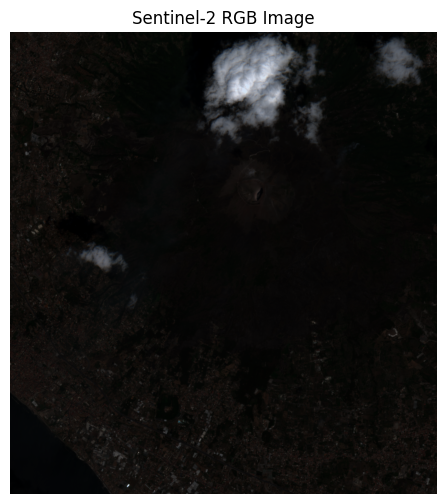

RGB image saved successfully: ./outputs/sentinel2_rgb.png


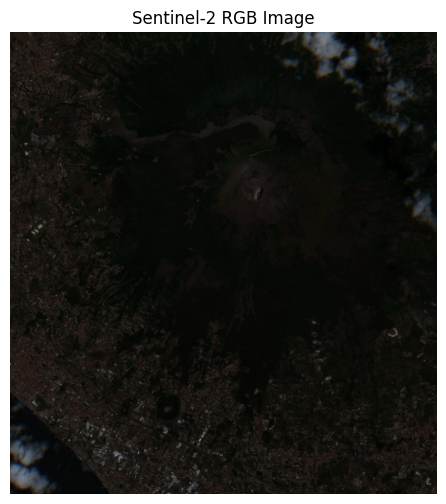

RGB image saved successfully: ./outputs/sentinel2_rgb.png


In [5]:
_raster_data.visualize_rgb(AreaType.BURNED)
_raster_data.visualize_rgb(AreaType.UNBURNED)

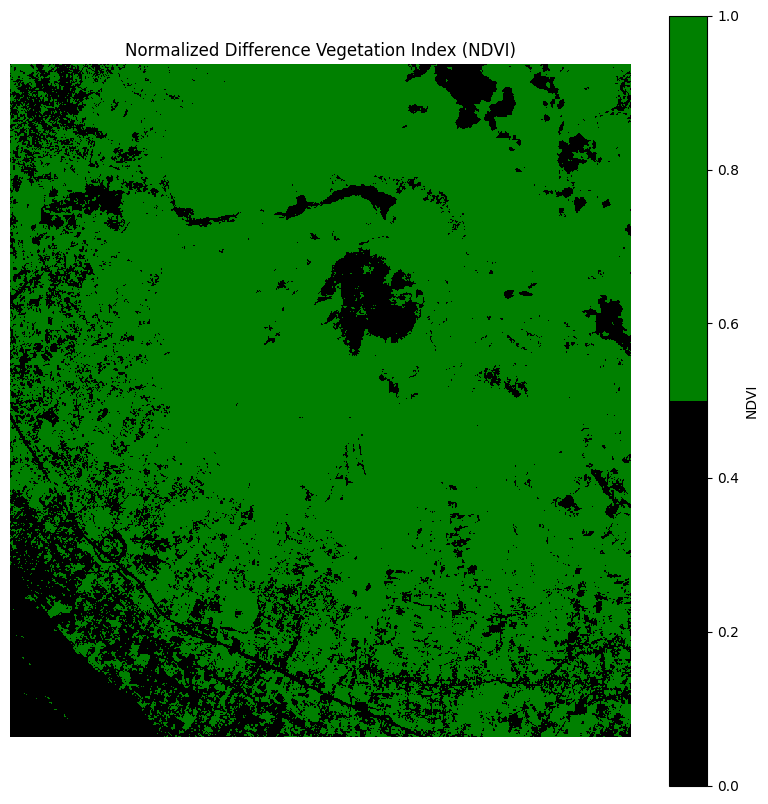

In [6]:
_unburned=_analyzer.visualize_ndvi_with_threshold(_raster_data.src(AreaType.UNBURNED),threshold=0.33,verbose=True)

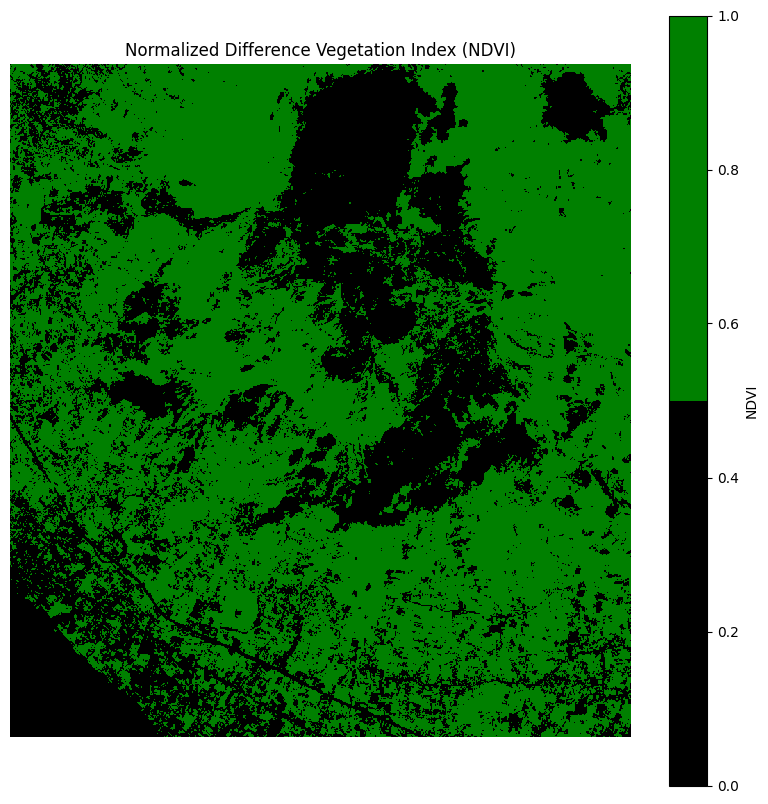

In [7]:
_burned=_analyzer.visualize_ndvi_with_threshold(_raster_data.src(AreaType.BURNED),threshold=0.33,verbose=True)

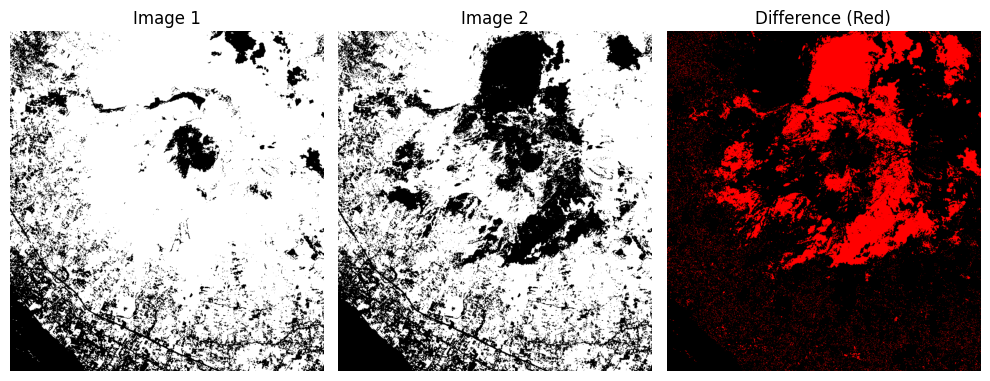

In [8]:
_analyzer.visualize_image_difference(_unburned, _burned)

In [9]:
dnbr = _analyzer.visualize_ndvi_with_threshold(_raster_data.src(AreaType.UNBURNED)) - _analyzer.visualize_ndvi_with_threshold(_raster_data.src(AreaType.BURNED))

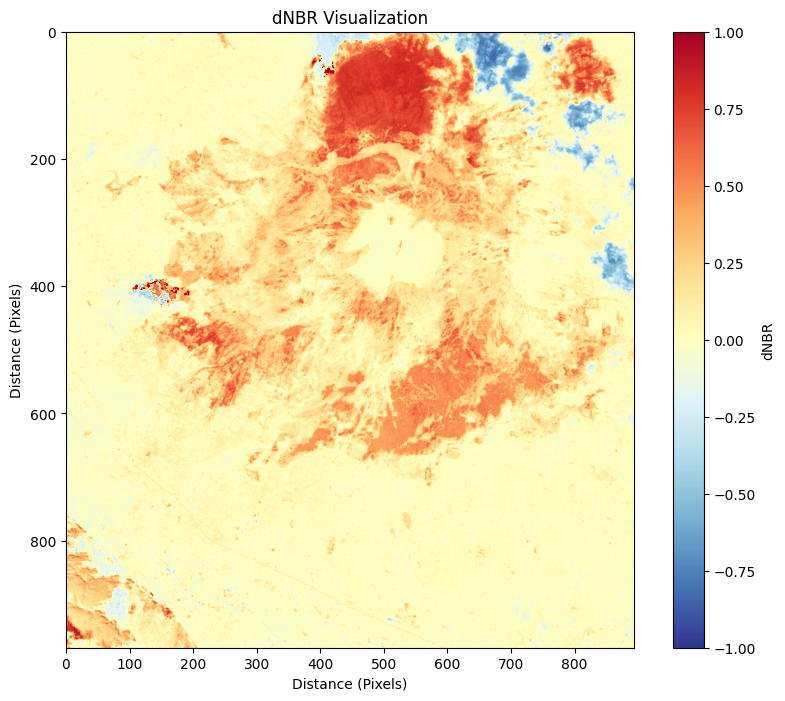

In [10]:
dnbr=_analyzer.visualize_dnbr(dnbr)

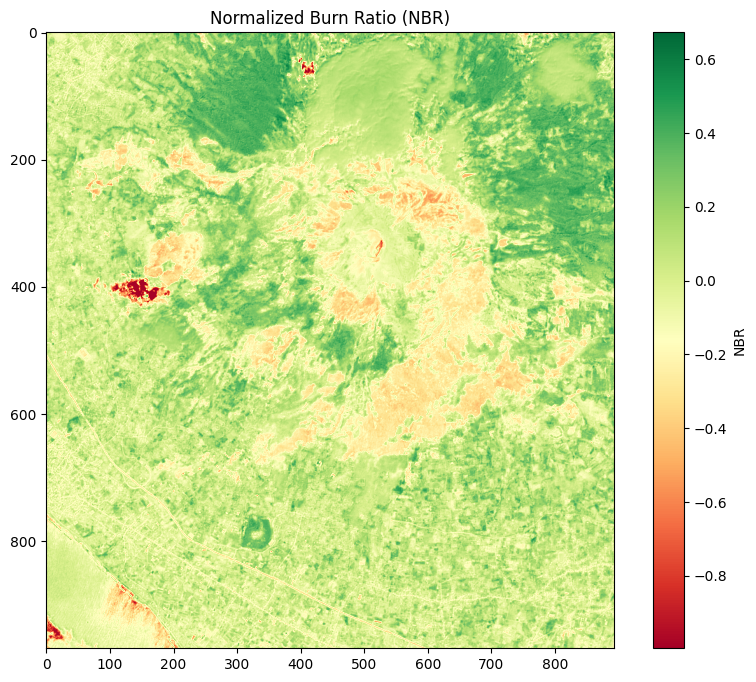

In [11]:
nbr=_analyzer.calculate_and_plot_nbr(_raster_data.src(AreaType.BURNED))

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image  # Eğer PIL kütüphanesi yüklü değilse, yüklemek için: pip install pillow

# Görüntülerin boyutlarının aynı olduğundan emin olma
assert dnbr.shape == nbr.shape, "Görüntülerin boyutları aynı olmalı"

In [13]:
# Görüntülerin ortalamasını alarak yeni bir görüntü oluşturma
averaged_image_plus = dnbr+nbr
averaged_image = dnbr-nbr
boosted=2*nbr

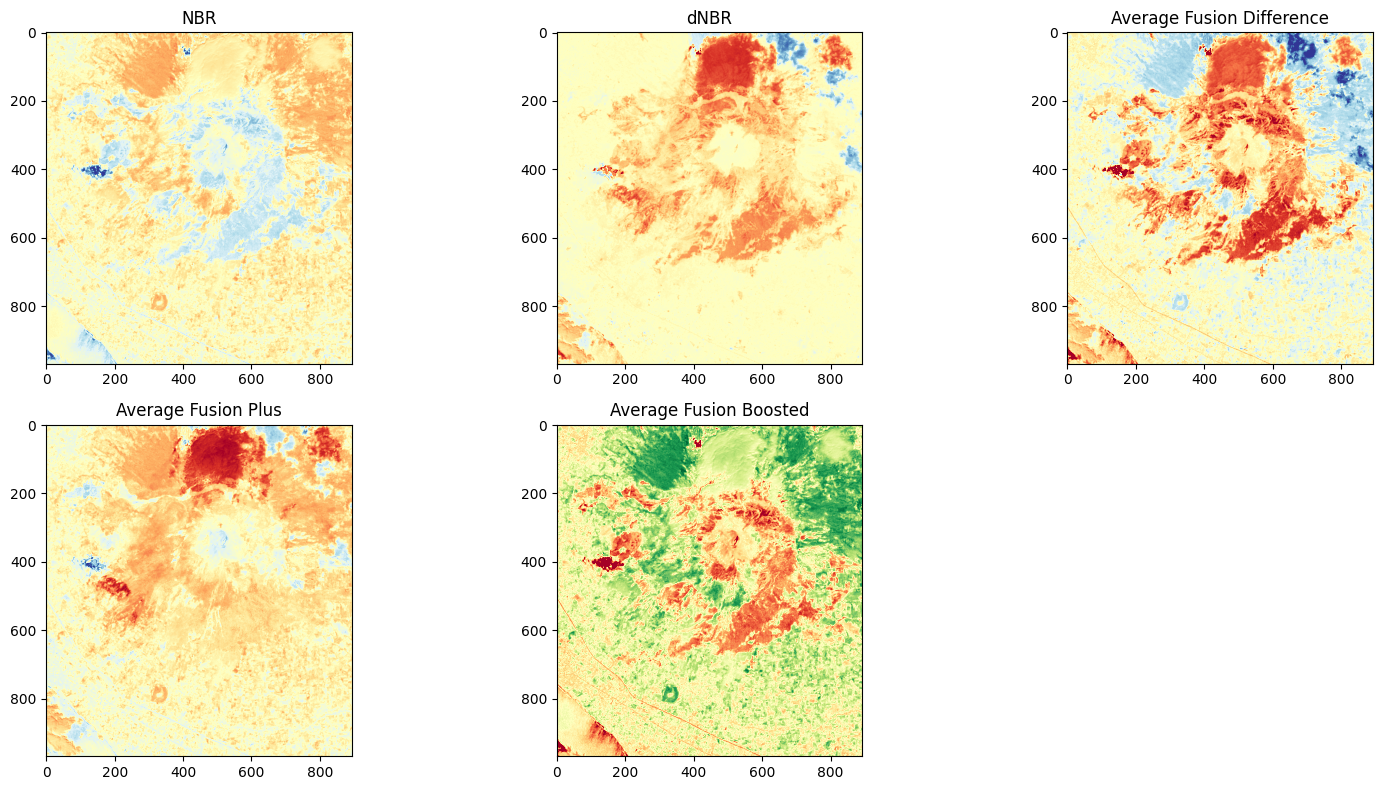

In [14]:
# Sonuçları görselleştirme
plt.figure(figsize=(16, 8))

plt.subplot(2, 3, 1)
plt.imshow(nbr, cmap='RdYlBu_r', vmin=-1, vmax=1)
plt.title('NBR')

plt.subplot(2, 3, 2)
plt.imshow(dnbr, cmap='RdYlBu_r', vmin=-1, vmax=1)
plt.title('dNBR')

plt.subplot(2, 3, 3)
plt.imshow(averaged_image.astype(np.float32), cmap='RdYlBu_r', vmin=-1, vmax=1)
plt.title('Average Fusion Difference')

plt.subplot(2, 3, 4)
plt.imshow(averaged_image_plus.astype(np.float32), cmap='RdYlBu_r', vmin=-1, vmax=1)
plt.title('Average Fusion Plus')

plt.subplot(2, 3, 5)
plt.imshow(boosted.astype(np.float32), cmap='RdYlGn', vmin=-1, vmax=1)
plt.title('Average Fusion Boosted')

plt.tight_layout()
plt.show()

In [15]:
# boosted'ı np.float32 türüne dönüştürdüğümüzü varsayalım
boosted_float32 = boosted.astype(np.float32)

# Normalizasyon için minimum ve maksimum değerlerini bulma
min_val = np.min(boosted_float32)
max_val = np.max(boosted_float32)

# 0 ile 1 arasında normalize etme
normalized = (boosted_float32 - min_val) / (max_val - min_val)

In [16]:
# Eşik değeri
threshold = 0.5

# Eşik değerine göre siyah-beyaz yapma
binary_image = np.where(normalized > threshold, 1.0, 0.0)

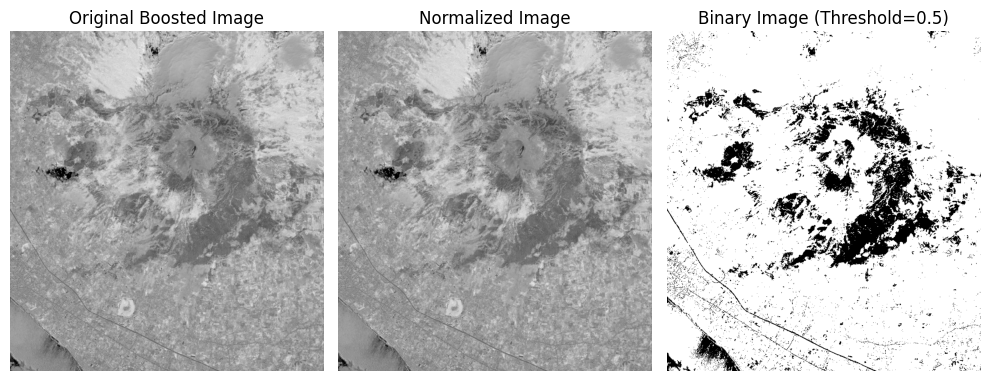

In [17]:
# Görselleştirme
plt.figure(figsize=(10, 5))

# Orjinal boosted görüntüsü
plt.subplot(1, 3, 1)
plt.imshow(boosted, cmap='gray')
plt.title('Original Boosted Image')
plt.axis('off')

# Normalize edilmiş görüntü
plt.subplot(1, 3, 2)
plt.imshow(normalized, cmap='gray')
plt.title('Normalized Image')
plt.axis('off')

# Eşik değerine göre siyah-beyaz görüntü
plt.subplot(1, 3, 3)
plt.imshow(binary_image, cmap='gray')
plt.title('Binary Image (Threshold={})'.format(threshold))
plt.axis('off')

plt.tight_layout()
plt.show()

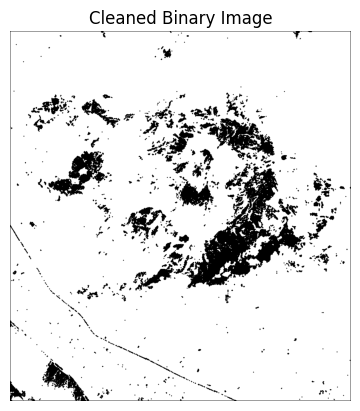

In [18]:
from scipy.ndimage import binary_closing

# binary_image üzerinde küçük siyah bölgeleri kapatma işlemi
cleaned_image = binary_closing(binary_image).astype(float)

# Görselleştirme
plt.imshow(cleaned_image, cmap='gray')
plt.title('Cleaned Binary Image')
plt.axis('off')
plt.show()

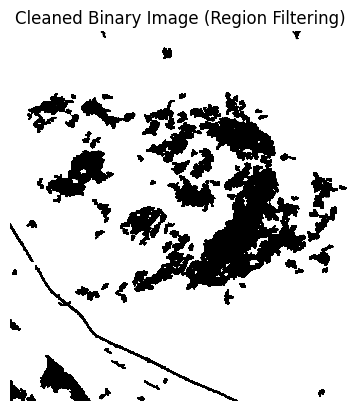

In [19]:
from skimage.measure import label, regionprops

# Görüntünün tersini almak için:
inverted_cleaned_image = 1 - binary_image  # 0'ları 1 yap, 1'leri 0 yap

threshold_area=50
# Bölge etiketleme ve filtreleme
labeled_image = label(inverted_cleaned_image)
regions = regionprops(labeled_image)

# Örneğin, belirli bir alan sınırlarında olan bölgeleri seçme
min_area = 1
max_area = 75
selected_regions = [region for region in regions if min_area <= region.area <= max_area]

# Gürültü olarak kabul edilen küçük bölge piksellerini temizleme
for region in selected_regions:
    if region.area < threshold_area:
        labeled_image[labeled_image == region.label] = 0

_cleaned_image = labeled_image.astype(float)

# Görselleştirme
plt.imshow(1-_cleaned_image, cmap='gray', vmin=0, vmax=1)
plt.title('Cleaned Binary Image (Region Filtering)')
plt.axis('off')
plt.show()


In [20]:
import numpy as np
from scipy.ndimage import label, find_objects
from skimage.measure import regionprops


# Bölge etiketleme yapma
labeled_image, num_features = label(binary_image)

# Bölge özelliklerini hesaplama
regions = regionprops(labeled_image)

print(len(regions))

1382


In [21]:
# Tüm bölge alanlarını bir listeye kaydetme
# Örneğin, belirli bir alan sınırlarında olan bölgeleri seçme
min_area = 1
max_area = 20000
selected_regions = [region for region in regions if min_area <= region.area <= max_area]

region_areas = [region.area for region in selected_regions]
print(len(region_areas))

1381


In [22]:
print(int(max(region_areas)))

1390


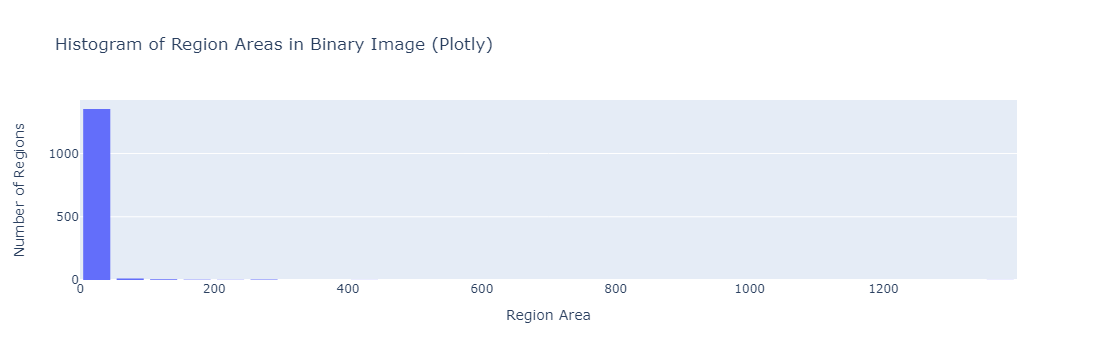

In [23]:
# Histogramı çizme
import plotly.graph_objects as go

fig = go.Figure(data=[go.Histogram(x=region_areas, nbinsx=50)])

fig.update_layout(
    title='Histogram of Region Areas in Binary Image (Plotly)',
    xaxis_title='Region Area',
    yaxis_title='Number of Regions',
    bargap=0.1,  # Bar arasındaki boşluğu ayarlar
    bargroupgap=0.1  # Gruplar arasındaki boşluğu ayarlar
)

fig.show()

In [24]:
import numpy as np
from skimage.metrics import mean_squared_error
from PIL import Image
from skimage.metrics import structural_similarity as ssim


_mask = "./Satellite_burned_area_dataset_part1/EMSR213_01VESUVIO_02GRADING_MAP_v2_vector/EMSR213_01VESUVIO_02GRADING_MAP_v2_vector_mask.png"

# İlk görüntüyü yükle
img1 = Image.open(_mask)
img1 = np.array(img1)
# Load the first image
img1 = np.array(img1, dtype=np.float64) / 255.0  # Normalize pixel values to [0, 1]

_cleaned_image[_cleaned_image != 0] = 1

# MSE hesapla
mse = mean_squared_error(img1, _cleaned_image)

print(f"Mean Squared Error (MSE) değeri: {mse}")

Mean Squared Error (MSE) değeri: 0.08571624458068795
